#Wymagania

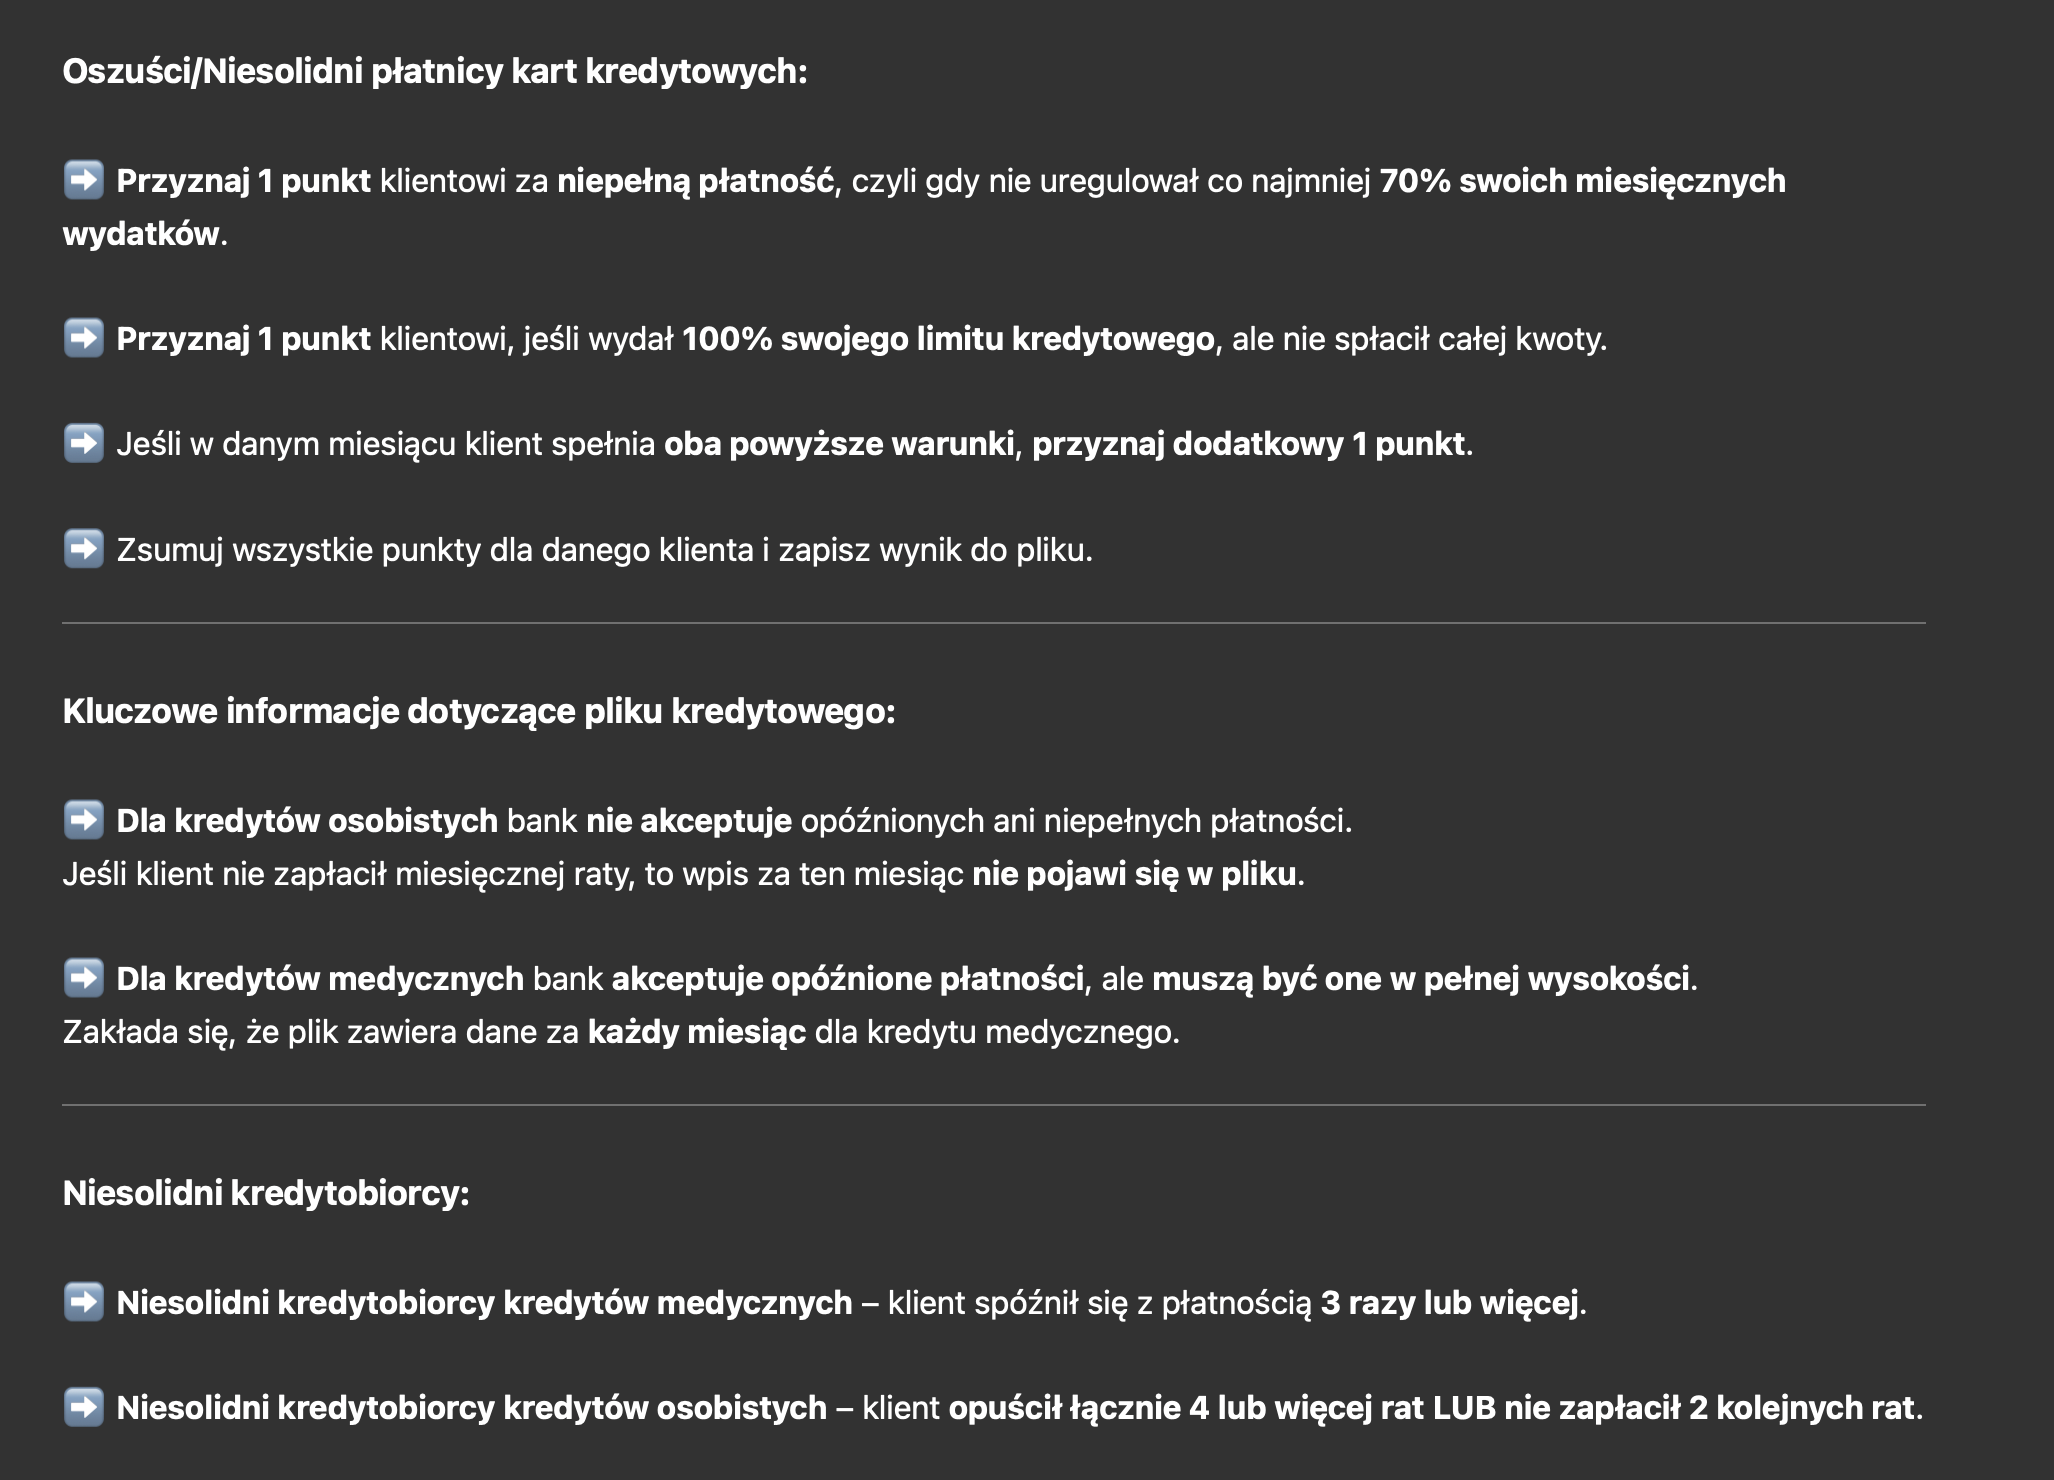

#Setup

In [3]:
!pip install apache-beam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313

In [1]:
import pandas as pd

df = pd.read_csv('/content/cards.txt', delimiter=',')
df.head(5)

,#Customer_id,First_name,Last_name,Relationship_no.,Card_type,Max_credit_limit,Total_Spent,Cash_withdrawn,Cleared_amount,Last_date
0,CT28383,Miyako,Burns,R_7488,Issuers,500,490,38,101,30-01-2018
1,CT28383,Miyako,Burns,R_7488,Issuers,500,224,69,224,28-02-2018
2,CT28383,Miyako,Burns,R_7488,Issuers,500,374,38,374,31-03-2018
3,CT28383,Miyako,Burns,R_7488,Issuers,500,224,69,0,30-04-2018
4,CT28383,Miyako,Burns,R_7488,Issuers,500,409,97,300,31-05-2018


In [2]:
df = pd.read_csv('/content/loan.txt', delimiter=',')
df.head(5)

,#customer_id,first_name,last_name,customer_category,loan_id,loan_category,due_date,due_amount,payment_date
0,CT88330,Humberto,Banks,Serviceman,LN_1559,Medical Loan,26-01-2018,2000,30-01-2018
1,CT88330,Humberto,Banks,Serviceman,LN_1559,Medical Loan,22-02-2018,2000,28-02-2018
2,CT88330,Humberto,Banks,Serviceman,LN_1559,Medical Loan,22-03-2018,2000,28-03-2018
3,CT88330,Humberto,Banks,Serviceman,LN_1559,Medical Loan,29-04-2018,2000,29-04-2018
4,CT88330,Humberto,Banks,Serviceman,LN_1559,Medical Loan,30-05-2018,2000,30-05-2018


#Beam

In [3]:
import apache_beam as beam
from datetime import datetime

# Tworzenie potoku Apache Beam
p = beam.Pipeline()

def calculate_points(element):
    # Rozdzielenie wiersza CSV na poszczególne wartości
    customer_id, first_name, last_name, relationship_id, card_type, max_limit, spent, cash_withdrawn, payment_cleared, payment_date = element.split(',')

    # Konwersja odpowiednich wartości na liczby całkowite
    spent = int(spent)
    payment_cleared = int(payment_cleared)
    max_limit = int(max_limit)

    # Klucz identyfikujący klienta
    key_name = f"{customer_id}, {first_name} {last_name}"
    defaulter_points = 0

    # Sprawdzenie, czy spłata wynosi mniej niż 70% wydanej kwoty
    if payment_cleared < (spent * 0.7):
        defaulter_points += 1

    # Sprawdzenie, czy wydatki osiągnęły limit karty i nie została uregulowana całość
    if spent == max_limit and payment_cleared < spent:
        defaulter_points += 1

    # Dodatkowy punkt, jeśli oba warunki są spełnione
    if spent == max_limit and payment_cleared < (spent * 0.7):
        defaulter_points += 1

    return key_name, defaulter_points

def calculate_late_payment(elements):
    # Konwersja daty na obiekt datetime
    due_date = datetime.strptime(elements[6].strip(), '%d-%m-%Y')
    payment_date = datetime.strptime(elements[8].strip(), '%d-%m-%Y')

    # Oznaczenie opóźnienia w płatności (1 - spóźniona, 0 - na czas)
    elements.append('1' if payment_date > due_date else '0')
    return elements

def calculate_month(input_list):
    # Pobranie miesiąca z daty płatności
    payment_date = datetime.strptime(input_list[8].strip(), '%d-%m-%Y')
    input_list.append(str(payment_date.month))
    return input_list

def calculate_personal_loan_defaulter(input):
    max_allowed_missed_months = 4
    max_allowed_consecutive_missing = 2

    name, months_list = input
    months_list.sort()
    total_payments = len(months_list)
    missed_payments = 12 - total_payments

    if missed_payments > max_allowed_missed_months:
        return name, missed_payments

    # Sprawdzenie liczby kolejnych opuszczonych miesięcy
    consecutive_missed_months = max(
        max(months_list[i] - months_list[i-1] - 1 for i in range(1, len(months_list))),
        12 - months_list[-1]
    )

    if consecutive_missed_months > max_allowed_consecutive_missing:
        return name, consecutive_missed_months

    return name, 0

def format_result(sum_pair):
    key_name, points = sum_pair
    return f"{key_name}, {points} fraud_points"

def format_output(sum_pair):
    key_name, miss_months = sum_pair
    return f"{key_name}, {miss_months} missed"

def return_tuple(element):
    thisTuple = element.split(',')
    return thisTuple[0], thisTuple[1:]

# Przetwarzanie danych kart kredytowych
card_defaulter = (
    p
    | 'Read credit card data' >> beam.io.ReadFromText('cards.txt', skip_header_lines=1)
    | 'Calculate defaulter points' >> beam.Map(calculate_points)
    | 'Combine points for defaulters' >> beam.CombinePerKey(sum)
    | 'Filter card defaulters' >> beam.Filter(lambda element: element[1] > 0)
    | 'Format output' >> beam.Map(format_result)
    | 'Convert to tuple' >> beam.Map(return_tuple)
)

# Przetwarzanie danych dotyczących kredytów medycznych
medical_loan_defaulter = (
    p
    | 'Read loan data' >> beam.io.ReadFromText('loan.txt', skip_header_lines=1)
    | 'Split Row' >> beam.Map(lambda row: row.split(','))
    | 'Filter medical loan' >> beam.Filter(lambda element: element[5].strip() == 'Medical Loan')
    | 'Calculate late payment' >> beam.Map(calculate_late_payment)
    | 'Make key value pairs' >> beam.Map(lambda elements: (f"{elements[0]}, {elements[1]} {elements[2]}", int(elements[9])))
    | 'Group medical loan based on month' >> beam.CombinePerKey(sum)
    | 'Check for medical loan defaulter' >> beam.Filter(lambda element: element[1] >= 3)
    | 'Format medical loan output' >> beam.Map(format_output)
)

# Przetwarzanie danych dotyczących kredytów osobistych
personal_loan_defaulter = (
    p
    | 'Read personal loan data' >> beam.io.ReadFromText('loan.txt', skip_header_lines=1)
    | 'Split personal loan row' >> beam.Map(lambda row: row.split(','))
    | 'Filter personal loan' >> beam.Filter(lambda element: element[5].strip() == 'Personal Loan')
    | 'Calculate payment month' >> beam.Map(calculate_month)
    | 'Make key value pairs' >> beam.Map(lambda elements: (f"{elements[0]}, {elements[1]} {elements[2]}", int(elements[9])))
    | 'Group personal loan based on month' >> beam.GroupByKey()
    | 'Check for personal loan defaulter' >> beam.Map(calculate_personal_loan_defaulter)
    | 'Filter only personal loan defaulters' >> beam.Filter(lambda element: element[1] > 0)
    | 'Format personal loan output' >> beam.Map(format_output)
)

# Łączenie wyników defaultersów kredytowych
final_loan_defaulters = (
    (personal_loan_defaulter, medical_loan_defaulter)
    | 'Combine all defaulters' >> beam.Flatten()
    | 'Convert to tuple for loan' >> beam.Map(return_tuple)
)

# Łączenie danych kart kredytowych i kredytów
both_defaulters = (
    {'card_defaulter': card_defaulter, 'loan_defaulter': final_loan_defaulters}
    | 'Group both defaulters' >> beam.CoGroupByKey()
    | 'Write final output' >> beam.io.WriteToText('outputs/both')
)

# Uruchomienie potoku
p.run()

In [5]:
!{('head -n 20 /content/outputs/both-00000-of-00001')}

('CT28383', {'card_defaulter': [[' Miyako Burns', ' 3 fraud_points']], 'loan_defaulter': []})
('CT74474', {'card_defaulter': [[' Nanaho Brennan', ' 3 fraud_points']], 'loan_defaulter': [[' Nanaho Brennan', ' 5 missed']]})
('CT66322', {'card_defaulter': [[' Chris Bruce', ' 1 fraud_points']], 'loan_defaulter': [[' Chris Bruce', ' 8 missed']]})
('CT65528', {'card_defaulter': [[' Bonnie Barlow', ' 2 fraud_points']], 'loan_defaulter': []})
('CT84463', {'card_defaulter': [[' Isaac Bowman', ' 4 fraud_points']], 'loan_defaulter': [[' Isaac Bowman', ' 3 missed']]})
('CT12838', {'card_defaulter': [[' Isidore Albert', ' 5 fraud_points']], 'loan_defaulter': []})
('CT96185', {'card_defaulter': [[' Danielle Bradshaw', ' 3 fraud_points']], 'loan_defaulter': []})
('CT74827', {'card_defaulter': [[' Hanna Boyer', ' 3 fraud_points']], 'loan_defaulter': []})
('CT98239', {'card_defaulter': [[' Sayuri Case', ' 4 fraud_points']], 'loan_defaulter': []})
('CT57141', {'card_defaulter': [[' Kaori Brown', ' 2 fra